In [3]:
import numpy as np
from sympy.abc import x,y,z
from sympy import ordered, Matrix, hessian, lambdify
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#init_printing()
from misc_tools.print_latex import print_tex

resources:

https://indrag49.github.io/Numerical-Optimization/quasi-newton-methods.html

# Second-Order Methods

## Newton's Method

First derivative can give us only direction. Line approximation does have a minimum nor maximum. With local quadratic approximation we construct a parabola, which has a minima.

We have seen in [Notes_optimization_general_sketch.ipynb](Notes_optimization_general_sketch.ipynb)

$$f(x^* \pm h) = f(x^*) \pm h  f'(x^*) + \frac{h^2}{2} f''(x^*) + \underbrace{O(h^3)}_{\approx 0}$$

one can rewrite it as
$$x = x_0 + dx \longleftrightarrow dx = x - x_0$$
$$f(x) =f(x_0 + dx) = f(x_0) +  dx \cdot f'(x_0) + \frac{dx^2}{2} \cdot f''(x_0) + \underbrace{O(dx^3)}_{\approx 0}$$
$$\boxed{f(x) = f(x_0) + (x - x_0)\cdot f'(x_0) + \frac{(x - x_0)^2}{2} \cdot f''(x_0)}$$

this approximation has extremum
$$\frac{\partial}{\partial x} f(x) = f'(x_0)  + (x_{min} - x_0)\cdot f''(x_0) = 0$$
_Note that Taylor series is a polynomial in $x$ and terms $f^{(i)}(x_0)$ are constants._

$$x_{min} - x_0 = - \frac{f'(x_0)}{f''(x_0)}$$
$$\boxed{x_{i+1} = x_i - \frac{f'(x_i)}{f''(x_i)}}$$

This is the estimate of where local minimum could be if quadratic fit is perfect. 

If fit is bad, prediction degrades rapidly. Division by second derivative also brings problems, in case if its low or zero.

For multivariate problem $\vec{x} \in \R^n$:

$$f(\vec{x}) \approx f(\vec{x}_0) + \nabla f(\vec{x}_0) \cdot (\vec{x} - \vec{x}_0) + \frac{1}{2} (\vec{x} - \vec{x}_0)\cdot H(\vec{x}_0) (\vec{x} - \vec{x}_0)$$

$$\nabla f(\vec{x}) = \nabla f(\vec{x}_0) + H(\vec{x}_0) (\vec{x}- \vec{x}_0) = \vec{0}$$

$$\vec{x} = \vec{x}_0 + H(\vec{x}_0)^{-1}  \nabla f(\vec{x}_0)$$


$$\boxed{\vec{x}_{i+1} = \vec{x}_{i} + H(\vec{x}_{i})^{-1}  \nabla f(\vec{x}_{i})}$$

_Notice that we dont have a learning rate/ step size. Hessian acts as a transformation for step direction (opposite the gradient). So it is a special case of:_
$$\vec{x}_{i+1} = \vec{x}_i - \alpha \vec{d}_i$$ 

In [4]:
v = [x,y]
#f           = (x + 2*y - 7)**2 + (2*x+y-5)**2
a,b         = 1,100
f           = (a - x)**2 + b*(y-x**2)**2

grad_f      = Matrix([f]).jacobian(v)
hessian_f   = hessian(f,v)
f_L         = lambdify(v, f         , 'numpy')
grad_f_L    = lambdify(v, grad_f    , 'numpy')
hess_f_L    = lambdify(v, hessian_f , 'numpy')

display(grad_f),display(hessian_f);

Matrix([[-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]])

Matrix([
[1200*x**2 - 400*y + 2, -400*x],
[               -400*x,    200]])

In this example Hessian is positive- semidefinite everywhere. Means that a function is a 'pot'.

In [5]:
def plot_grad(traj, dom1,dom2,dom3, sp = 100):
    fig, ax1 = plt.subplots()
    X,Y = np.meshgrid(np.linspace(*dom1[0],sp),np.linspace(*dom1[1],sp))
    Z   = f_L(X,Y)
    Z -= Z.min() - 0.0001
    norm = colors.LogNorm(vmin=Z.min(), vmax=Z.max())
    ax1.contourf(X,Y,Z, levels = 10, norm=norm);
    ax1.plot(*np.array(traj).T, c = 'k')
    ax1.scatter(*np.array(traj).T, c = 'k', s= 4)
    left, bottom, width, height = [1, 0.53, 0.35, 0.35]
    ax2 = fig.add_axes([left, bottom, width, height])
    xmin,xmax = dom2[0]
    ymin,ymax = dom2[1]
    X,Y = np.meshgrid(np.linspace(*dom2[0],sp),np.linspace(*dom2[1],sp))
    Z   = f_L(X,Y)
    Z -= Z.min() - 0.0001
    ax2.contourf(X,Y,Z, levels = 10, norm=norm);
    ax2.plot(*np.array(traj).T, c = 'k')
    ax2.set_xlim(xmin,xmax)
    ax2.set_ylim(ymin,ymax)

    left, bottom, width, height = [1, 0.1, 0.35, 0.35]
    ax3 = fig.add_axes([left, bottom, width, height])
    s = 0.9
    xmin,xmax = dom3[0]
    ymin,ymax = dom3[1]
    X,Y = np.meshgrid(np.linspace(*dom3[0],sp),np.linspace(*dom3[1],sp))
    Z   = f_L(X,Y)
    Z -= Z.min() - 0.0001
    ax3.contourf(X,Y,Z, levels = 10, norm=norm);
    ax3.plot(*np.array(traj).T, c = 'k')
    ax3.set_xlim(xmin,xmax)
    ax3.set_ylim(ymin,ymax)

[0.99964436 0.99927905]


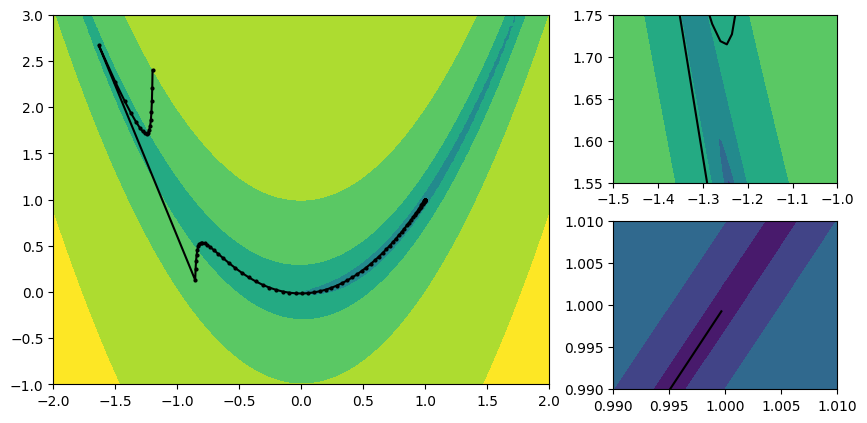

In [20]:
x = np.array([-1.2,2.4]) # Starting point
lr = 0.2
num_iterations = 20000
traj = [x.copy()]
for i in range(num_iterations):
    g = grad_f_L(*x)[0]
    H_inv = np.linalg.inv(hess_f_L(*x))
    Hg = H_inv @ g
    x -= lr*Hg
    traj.append(x.copy())
    if np.linalg.norm(x - 1) < 0.001:
        break

print(traj[-1])
dom1 = ((-2,2),(-1,3))
dom2 = ((-1.5, -1),(1.55,1.75))
dom3 = ((1-0.01, 1+0.01), (1-0.01, 1+0.01))
plot_grad(traj, dom1,dom2,dom3)

## Secant Method
We can avoid calculating second order derivatives by estimating them

$$f''(x_{i}) \approx \frac{f'(x_{i})  - f'(x_{i-1})}{x_{i} - x_{i-1}}$$

so
$$x_{i+1} = x_i - \frac{f'(x_i)}{f''(x_i)} \longrightarrow  x_{i+1} =  x_i - \frac{f'(x_i)}{\frac{f'(x_{i})  - f'(x_{i-1})}{x_{i} - x_{i-1}}}$$

$$\boxed{x_{i+1} = x_i - \frac{x_{i} - x_{i-1}}{f'(x_{i})  - f'(x_{i-1})} f'(x_i)}$$

_Note: I am not really interested in 1D methods. Skip._

## Quasi-Newton Methods
### Secant equation
(from https://youtu.be/2eSrCuyPscg)

Inverse Hessian may be difficult to compute, so we can approximate it, or at least what it does with another transformation $B$
$$B \vec{d} = -  \nabla f$$
_TBH i dont understand why write $B$ on left side._

$$\vec{x}_{i+1} = \vec{x}_i - \alpha \vec{d}_i \rightarrow \vec{x}_i + \alpha B^{-1} \vec{d} $$
 
What could be a reasonable guess for $B$? Since hessian is a "derivative of a gradient", one could write Taylor's-like expansion
$$f(\vec{x}_0 + \vec{\Delta s}) \approx f(\vec{x}_0) + \nabla f(\vec{x}_0) \cdot \vec{\Delta s} + \frac{1}{2} \vec{\Delta s}\cdot H(\vec{x}_0) \vec{\Delta s}$$

$$\nabla f(\vec{x}_0 + \vec{\Delta s}) \approx   \nabla f(\vec{x}_0) + H(\vec{x}_0) \vec{\Delta s}$$
So we could extract $H = B$ from this expression and decide on update rule for $B$ so this expressions is satisfied at each iteration. 
$$\nabla f(\vec{x}_{i+1}) = \nabla f(\vec{x}_i) + B_i \vec{\Delta x_i}$$
This update rule can be derived form same expression. One change is that we re-use old values and available values (maybe because $B_i \approx B_{i+1}$ close):

$$B_{i+1} \vec{\Delta x_i} = \nabla f(\vec{x}_{i+1})  - \nabla f(\vec{x}_i)$$
or
$$B_{i} \vec{\Delta x_{i-1}} = \nabla f(\vec{x}_{i})  - \nabla f(\vec{x}_{i-1})= \vec{\Delta y_{i-1}}$$
given
$$\vec{\Delta x_{i-1}} = \vec{x}_i - \vec{x}_{i-1}$$

Naturally in case of 1D this would be the same as secant method. But what to do if we are dealing with matrices?

We would like to preserve:
1. $B_{i+1}$ to be symmetric
2. $B_{i+1} \approx B_i$
3. $B$ stay positive definite

### Symmetric rank-one update (SR1, just briefly)
Simplest approximation and update step would be to construct $\Delta B$ from rank-one matrix (vector outer product)
$$B_{i+1} = B_i + a \vec{u}\vec{u}^T$$
In order to comply with secant equation:
$$B_{i+1} \vec{\Delta x_i}  = B_i \vec{\Delta x_i}  +  \vec{u}\underbrace{\vec{u}^T\vec{\Delta x_i}a}_{\text{scalar}} = \vec{\Delta y_{i}}$$

$$\vec{\Delta y_{i}} - B_i \vec{\Delta x_i} = a\vec{u}\vec{u}^T\vec{\Delta x_i} $$

$$a = \frac{\vec{\Delta y_{i}} - B_i \vec{\Delta x_i}}{\vec{u}\vec{u}^T\vec{\Delta x_i}}$$
$$B_{i+1} = B_i + a \vec{u}\vec{u}^T  $$
_TBH idk how but_

$$\boxed{B_{i+1} = B_i + \frac{(\Delta y - B\Delta x)(\Delta y - B\Delta x)^T}{(\Delta y - B\Delta x)^T \Delta x}}$$

Since we are interested in inverse $B^{-1}$, Sherman-Morrison-Woodbury formula gives similar rank-one expression for its update.

$$\boxed{H_{i+1} = H_i + \frac{(\Delta x - H \Delta y)(\Delta x - H y)^T}{(\Delta x -H\Delta y)^T \Delta y}}$$

https://en.wikipedia.org/wiki/Wolfe_conditions#Armijo_rule_and_curvature

finish: 3999


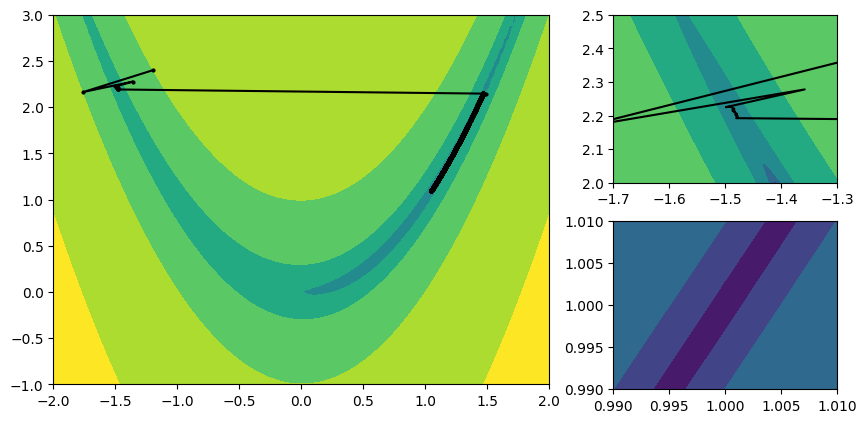

In [53]:
x = np.array([[-1.2,2.4]]).T # Starting point
H = np.eye(2)
eps = 1e-8
num_iterations = 4000
rho = 0.5
beta = 1e-4

traj = [x.T[0].copy()]
g = grad_f_L(*x.flatten()).T
for k in range(num_iterations):
    d       = - H @ g
    gd      = (g.T @ d)[0,0]
    f_x     = f_L(*x.flatten())
    alpha   = 5
    i       = 0
    sigma   = 0.9
    while True:
        x_new       = x + alpha*d
        f_xad       = f_L(*x_new.flatten())
        #print(f'{i = };\t {alpha = };\t {f_xad = :0.1f};\t {f_x + beta*alpha*gd = :0.3f};\t {x_new.flatten() = }')
        if f_xad <=  f_x + beta*alpha*gd:
            g_new   = grad_f_L(*x_new.flatten()).T
            if i > 100: break
            # gd2     = (g_new.T @ d)[0,0]
            # if -gd2 <= -sigma * gd: # Strong Wolfe condition on curvature
            #    break
            break
        alpha *= rho
        i += 1

    dx      = x_new - x
    dg      = g_new - g
    u       = dx - H @ dg
    ug      = u.T @ dg 
    if ug >= 1e-8 * np.linalg.norm(dg)*np.linalg.norm(u):
        H       = H + (u @ u.T)/(ug+ eps) 
        
    x       = x_new.copy()
    g       = g_new.copy()
    traj.append(x.flatten().copy())

    if np.linalg.norm(x - 1) < 0.001:
        break

print('finish:',k)
#print(traj)
dom1 = ((-2,2),(-1,3))
dom2 = ((-1.7, -1.3),(2,2.5))
dom3 = ((1-0.01, 1+0.01), (1-0.01, 1+0.01))
plot_grad(traj, dom1,dom2,dom3)

### Davidon-Fletcher-Powerll (DFP) Method
Is a rank-two update 

$$H_{i+1} = H_i + a \vec{u}_i \vec{u}_i^T + b \vec{v}_i \vec{v}_i^T$$

$$\vec{u} \rightarrow \Delta x \rightarrow  x \ ; \ \vec{v} \rightarrow \Delta y \rightarrow  y$$

Via secant equation 
$$B_{i+1} \Delta x_i = \Delta y_i \longleftrightarrow B_{i+1}^{-1}\Delta y = H_{i+1}\Delta y= \Delta x$$

$$ H_{i+1} y = H_i y + a \vec{u}_i \vec{u}_i^T y + b \vec{v}_i \vec{v}_i^T y = x$$
$$\dots$$
$$H_{i+1} = H_i - \frac{H_i y_i y_i^T H}{ y_i^T H y_i}+ \frac{x_i x_i^T}{x_i^Ty_i}$$

In [ ]:
u      = dx - H @ dg
H       = H + (u @ u.T)/(u.T @ dg + eps) 

finish: 156


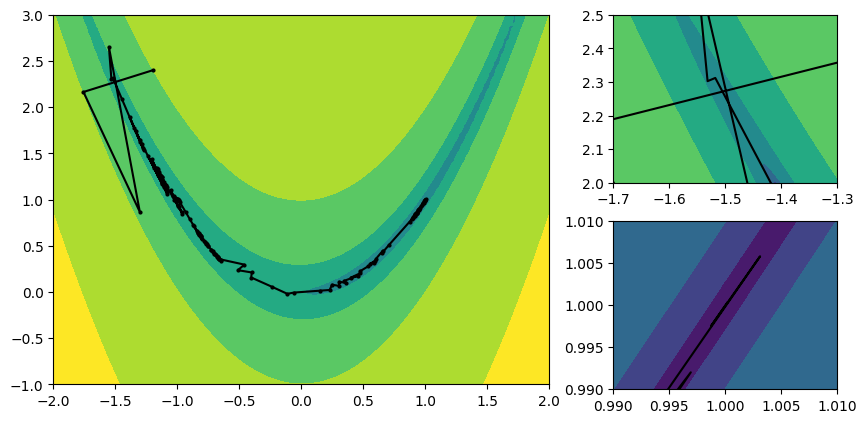

In [42]:
x = np.array([[-1.2,2.4]]).T # Starting point
H = np.eye(2)
eps = 1e-8
num_iterations = 4000
rho = 0.5
beta = 1e-4

traj = [x.T[0].copy()]
g = grad_f_L(*x.flatten()).T
for k in range(num_iterations):
    d       = - H @ g
    gd      = (g.T @ d)[0,0]
    f_x     = f_L(*x.flatten())
    alpha   = 5
    i       = 0
    sigma   = 0.9
    while True:
        x_new       = x + alpha*d
        f_xad       = f_L(*x_new.flatten())
        #print(f'{i = };\t {alpha = };\t {f_xad = :0.1f};\t {f_x + beta*alpha*gd = :0.3f};\t {x_new.flatten() = }')
        if f_xad <=  f_x + beta*alpha*gd:
            g_new   = grad_f_L(*x_new.flatten()).T
            if i > 100: break
            # gd2     = (g_new.T @ d)[0,0]
            # if -gd2 <= -sigma * gd: # Strong Wolfe condition on curvature
            #    break
            break
        alpha *= rho
        i += 1

    dx      = x_new - x
    dg      = g_new - g
    H       = H - (H @ dg @ dg.T @ H) / (dg.T @ H @ dg + eps) +(dx @ dx.T)/(dx.T @ dg+ eps)

    x       = x_new.copy()
    g       = g_new.copy()
    traj.append(x.flatten().copy())

    if np.linalg.norm(x - 1) < 0.001:
        break

print('finish:',k)
#print(traj)
dom1 = ((-2,2),(-1,3))
dom2 = ((-1.7, -1.3),(2,2.5))
dom3 = ((1-0.01, 1+0.01), (1-0.01, 1+0.01))
plot_grad(traj, dom1,dom2,dom3)

__IDK WHY THEY ARE THE SAME XD__